# Monte-Carlo Estimation & Simulated annealing


In [1]:
%matplotlib inline

import numpy as np
import scipy.linalg as sc
from math import *
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, expm, norm, block_diag
import matplotlib.animation as animation
import random
import time

# Ex 6.5 : Monte-Carlo

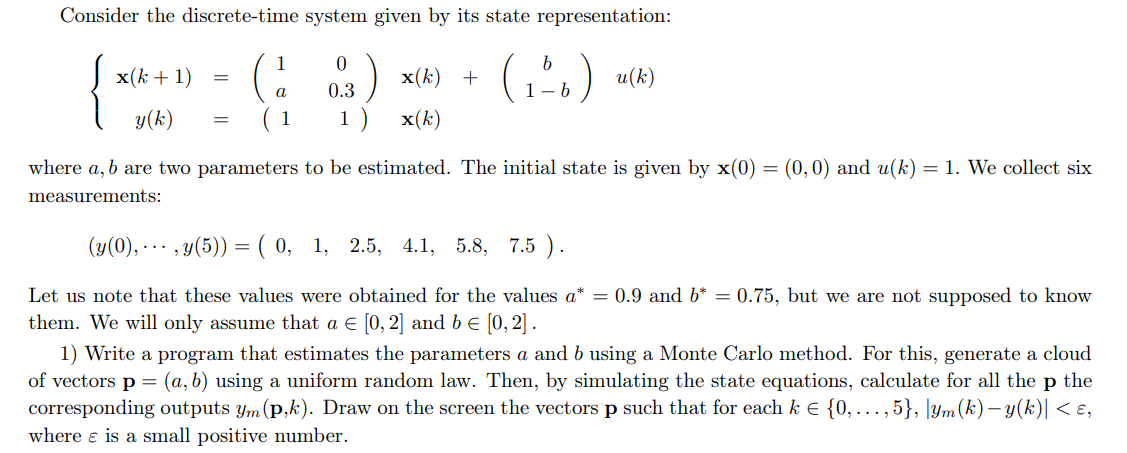

### 1)

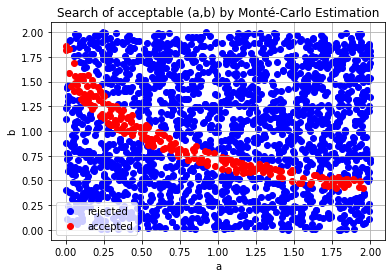

In [2]:
#2000 random points (a,b) in P
P = np.random.uniform(0,2, (2000, 2))

# blue values : rejected
a_b = []
b_b=[]

# red values : accepted
a_r = []
b_r = []

# epsilon criterion 
epsilon = 0.5

y_true = np.array([0,1,2.5, 4.1, 5.8, 7.5])
C = np.array([1,1])

plt.figure()
plt.grid()

# for each of the 2000 random pairs, 
# we verify that the corresponding Y1, ..., Y5 are close to the true value (by a max margin of epsilon).
# In that case (a,b) are accepted solutions
for i in range(2000):
    X = np.array([[0], [0]])
    Y = np.zeros(6)
    # computing Y1, ..., Y5
    for j in range(1,5):
        X = np.array([[1, 0],[P[i,0], 0.3]])@X + np.array([[P[i,1]], [1-P[i,1]]]).reshape((2,1))
        Y[j] = C@X
        
    # vector of absolute error between true y and estimated Y 
    abs_diff = np.abs(y_true - Y)
    
    #counting how many errors are < epsilon. If all are > epsilon, the criterion is fulfilled and (a,b) are accepted
    count_inf_epsilon = np.sum(abs_diff<epsilon)
    
    if count_inf_epsilon==5:
        # (a,b) is an accepted solution
        a_r.append(P[i,0])
        b_r.append(P[i,1])
    else:
        # rejected solution
        a_b.append(P[i, 0])
        b_b.append(P[i, 1])

plt.scatter(a_b, b_b, color = 'blue', label = 'rejected')
plt.scatter(a_r, b_r, color = 'red', label = "accepted")
plt.xlabel('a')
plt.ylabel('b')
plt.legend()
plt.title('Search of acceptable (a,b) by Monté-Carlo Estimation')
plt.show()


# Ex 6.6 : Simulated Annealing

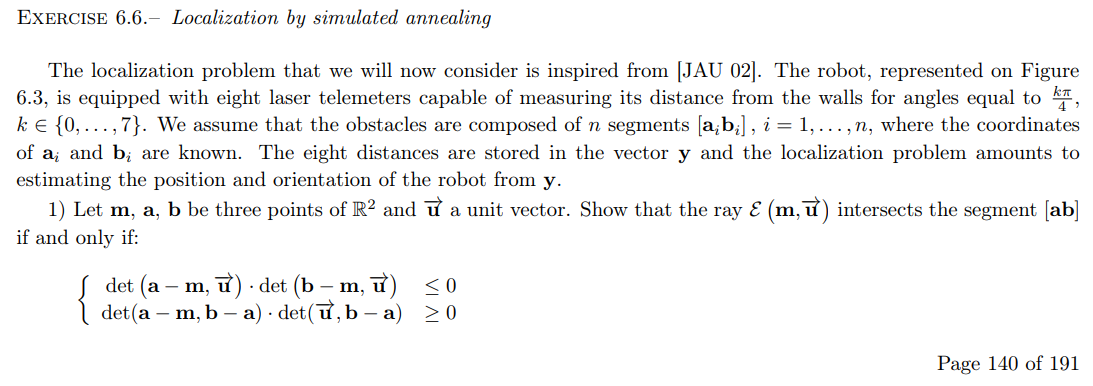

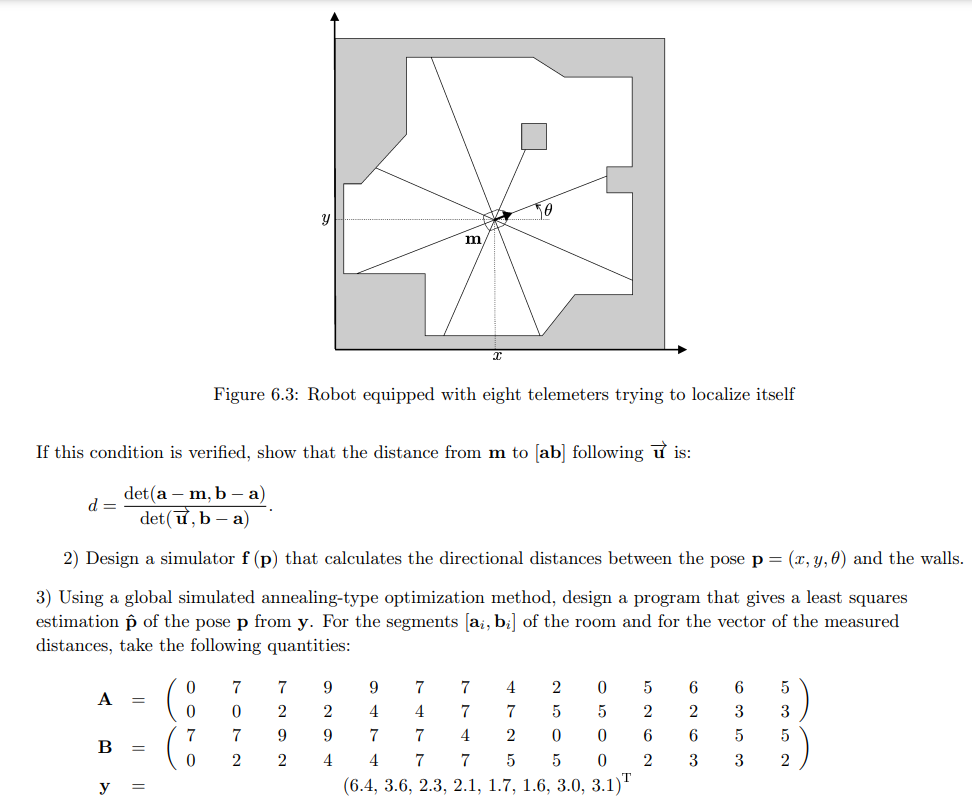

## 1) Expression of d

This question can be done by geometrical consideration, but won't be answered in this notebook as it is not its main purpose

## 2) Simulator f(p)

Designing the simulator, computing the distance between the position and the walls in each direction, following equation from 1)

In [3]:
# room edges and distance vector y

A = np.array([[0,7,7,9,9,7,7,4,2,0,5,6,6,5],
                  [0,0,2,2,4,4,7,7,5,5,2,2,3,3]])
B = np.array([[7,7,9,9,7,7,4,2,0,0,6,6,5,5],
                  [0,2,2,4,4,7,7,5,5,0,2,3,3,2]])
Y = np.array([6.4, 3.6, 2.3, 2.1, 1.7, 1.6, 3.0, 3.1])

In [4]:
def f(p):
    """
    simulator, computing the distance between the position and the walls in each direction
    :param p: array position of robot (x, y, theta)
    :return D: list of the (8) lidar distances, computed following equation from 1)
    """
    D = []
    # cartesian position
    m = np.array([p[0], p[1]])
    
    # each laser is characterized by a rotation angle of pi/4 (compared to the previous laser) 
    for i in range(8):
        #directional vector of laser i after applying rotation of i*pi/4
        u = np.array([[np.cos(p[2]+ i*np.pi/4),np.sin(p[2]+ i*np.pi/4)]])
        
        #reference (or 1st approx) distance between p and wall, arbitrarily high
        ref = 1000
        
        #looping on A & B columns (wall / edges of room)
        for j in range(A.shape[1]):
            #np.array( [x , y] ) -> np.array( [ [x] , [y] ] ) -> np.array( [ [x , y] ] )
            a = A[:,j].reshape((2,1)).T
            b = B[:,j].reshape((2,1)).T
        
            # Detecting obstacles thanks to determinant (or eq 1). If so, we append distance d in D,
            # but it must be the lowest distance if 2 walls are detected on the same direction 
            if np.linalg.det(np.concatenate((a-m, u), axis = 0))*np.linalg.det(np.concatenate((b-m, u), axis = 0))<=0 and np.linalg.det(np.concatenate((a-m, b-a), axis = 0))*np.linalg.det(np.concatenate((u, b-a), axis = 0))>=0:
                d = np.linalg.det(np.concatenate((a-m, b-a), axis = 0))/np.linalg.det(np.concatenate((u, b-a), axis = 0))
                d = min(ref, d)
                ref = d
        D.append(ref)
    return D


## 3) Simulated annealing

The principle of the method is to try random positions for the robot and update it when one is better than the previous ones (lesser distance between y and f(p)). The radius of random search (Temperature) is decreased at each iteration, forcing convergence.

In [5]:
def annealing():
    # Temperature
    T= 5
    p0 = np.array([random.uniform(0,4),random.uniform(0,4),random.uniform(0,1)])
    yc = f(p0)
    while T>1e-2:
        x = random.uniform(-1  ,1)
        y= random.uniform(-1,1)
        theta =  random.uniform(0, 2*np.pi)
        p1 = p0 + T*np.array([x,y,theta])
        j0 = np.linalg.norm(f(p0) - Y)
        j1 = np.linalg.norm(f(p1) - Y)
        # comparing j1 and j0 to see if position is better
        if j1<j0:
            p0 = p1
            print("Temperature = {}, \np = {}, \nyc = {}, \nnorm = {}, ".format(T, p0, f(p0), np.linalg.norm(f(p0)-Y)))
            print("=====================================================================================")
        T = 0.95*T
    print("\np0 = {}, \nyc = {}, \n||y - yc|| = {}".format(p0, f(p0), np.linalg.norm(Y-f(p0))))


In [6]:
annealing()

Temperature = 1.7924296120427095, 
p = [2.14406348 3.03798176 6.73033858], 
yc = [5.3854221871563395, 3.4440867723570756, 2.1759544289437724, 2.272846311395531, 2.377849659202139, 3.2204576524009645, 3.369239747026574, 3.0274779038263397], 
norm = 2.0798800044361547, 
Temperature = 0.4049735540879639, 
p = [1.90428333 2.73543467 6.95165332], 
yc = [6.49324402556209, 2.474420884410928, 2.885634403889073, 1.917376219629664, 2.4265431474989017, 2.754242129249926, 3.4856421482973494, 3.117001249585253], 
norm = 1.936031784535549, 
Temperature = 0.020672631835860406, 
p = [1.90826659 2.72707526 6.95343686], 
yc = [6.497330652852495, 2.4828992881411676, 2.9003764358079596, 1.920987467894134, 2.4350526733682587, 2.745254469366246, 3.479897368635428, 3.11234349620178], 
norm = 1.9319028666823557, 

p0 = [1.90826659 2.72707526 6.95343686], 
yc = [6.497330652852495, 2.4828992881411676, 2.9003764358079596, 1.920987467894134, 2.4350526733682587, 2.745254469366246, 3.479897368635428, 3.112343496201

## Animation

<IPython.core.display.Javascript object>


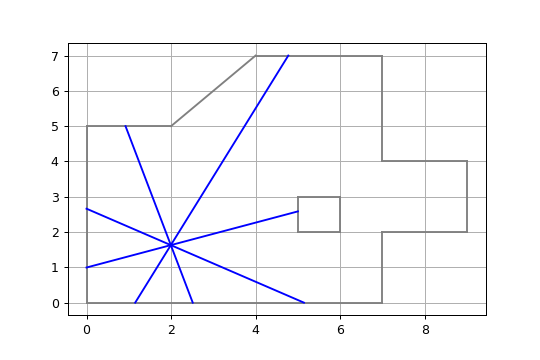

p0 = [ 1.99456015  1.6293426  45.07558787], 
yc = [6.047056846996346, 3.536986494431784, 2.245762060532294, 2.0929840946386697, 1.834547733950094, 1.7097444540063458, 3.5454001351503717, 3.153746853799464], 
||y - yc|| = 0.6797260608168108


In [7]:

def draw_room():
    plt.grid()
    for j in range(A.shape[1]):
        plt.plot(np.array([A[0,j], B[0, j]]), np.array([A[1,j], B[1,j]]), color = 'grey')
#y = f(p) (list of 8 distances)

def draw_rob(p, y, clr='red'):
    #for each angle
    for i in range(8):
        plt.plot(p[0]+ np.array([0, y[i]*np.cos(p[2]+ i*np.pi/4)]), p[1] + np.array([0, y[i]*np.sin(p[2] + i*np.pi/4)]), color = clr)
        

def update_rob(p,y, clr ='red', pause = 1e-10):
    my_plot, = plt.plot([], [], color = clr)
    X=  np.zeros((8,2))
    Y = np.zeros((8,2))
    for i in range(8):
        X[i] = p[0] + np.array([0, y[i] * np.cos(p[2] + i * np.pi / 4)])
        Y[i] = p[1] + np.array([0, y[i] * np.sin(p[2] + i * np.pi / 4)])
    my_plot.set_data(X, Y)  # allow curve animation
    plt.pause(pause)  # necessary to plot
    my_plot.remove()

%matplotlib notebook

# Temperature
T= 5
p0 = np.array([random.uniform(0,4),random.uniform(0,4),random.uniform(0,1)])
yc = f(p0)
draw_room()

while T>1e-2:
    x = random.uniform(-1  ,1)
    y= random.uniform(-1,1)
    theta =  random.uniform(0, 2*np.pi)
    p1 = p0 + T*np.array([x,y,theta])
    j0 = np.linalg.norm(f(p0) - Y)
    j1 = np.linalg.norm(f(p1) - Y)
    if j1<j0:
        p0 = p1
        update_rob(p1, f(p1), 'green')
    T = 0.99*T
    update_rob(p1, f(p1))
draw_rob(p0,f(p0), 'blue')
print("p0 = {}, \nyc = {}, \n||y - yc|| = {}".format(p0, f(p0), np.linalg.norm(Y-f(p0))))


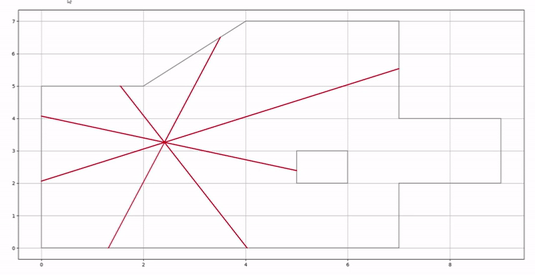